In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/leukemia-classification")

print("Path to dataset files:", path)

100%|██████████| 867M/867M [00:13<00:00, 69.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2


In [ ]:
import os

# List the contents of the downloaded directory
for root, dirs, files in os.walk(path):
    for name in files:
        print(os.path.join(root, name))


/root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/2200.bmp
/root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/2184.bmp
/root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/921.bmp
/root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/2152.bmp
/root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/637.bmp
/root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/966.bmp
/root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/2410.bmp
/root/.ca

###Preprocess the Data

In [2]:
import os
import cv2
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_path = '/root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2/C-NMC_Leukemia/training_data/fold_0'
val_path = '/root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2/C-NMC_Leukemia/training_data/fold_1'
test_path = '/root/.cache/kagglehub/datasets/andrewmvd/leukemia-classification/versions/2/C-NMC_Leukemia/training_data/fold_2'


class LeukemiaDataGenerator:
    def __init__(self, base_path, batch_size=32, img_size=(224, 224), augment=False, shuffle=True):
        self.base_path = base_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.label_encoder = LabelEncoder()
        self.samples = self._load_file_paths()
        self.on_epoch_end()

    def _load_file_paths(self):
        samples = []
        labels = []
        for label_folder in os.listdir(self.base_path):
            label_path = os.path.join(self.base_path, label_folder)
            if not os.path.isdir(label_path):
                continue
            for img_name in os.listdir(label_path):
                samples.append(os.path.join(label_path, img_name))
                labels.append(label_folder)
        self.label_encoder.fit(labels)
        return list(zip(samples, labels))

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, idx):
        batch_samples = self.samples[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = self._load_and_preprocess_batch(batch_samples)
        return np.array(X), np.array(y)

    def _load_and_preprocess_batch(self, batch_samples):
        X = []
        y = []
        for img_path, label in batch_samples:
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, self.img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype('float32') / 255.0

            X.append(img)
            y.append(label)

            if self.augment:
                # Horizontal flip
                X.append(cv2.flip(img, 1))
                y.append(label)

                # Random rotation
                angle = random.choice([90, 180, 270])
                M = cv2.getRotationMatrix2D((self.img_size[0] // 2, self.img_size[1] // 2), angle, 1)
                rotated = cv2.warpAffine(img, M, self.img_size)
                X.append(rotated)
                y.append(label)

                # Brightness jitter
                brightness = random.uniform(0.7, 1.3)
                bright = np.clip(img * brightness, 0, 1).astype(np.float32)
                X.append(bright)
                y.append(label)

        y = self.label_encoder.transform(y)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.samples)

In [3]:
train_gen = LeukemiaDataGenerator(train_path, batch_size=32, augment=True)
val_gen   = LeukemiaDataGenerator(val_path, batch_size=32, augment=False)
test_gen  = LeukemiaDataGenerator(test_path, batch_size=32, augment=False)

X_batch, y_batch = train_gen[0]
print("Batch shape:", X_batch.shape, y_batch.shape)


Batch shape: (128, 224, 224, 3) (128,)


###Data Visualisations

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def extract_all_labels(data_generator):
    all_labels = []
    for i in range(len(data_generator)):
        _, y_batch = data_generator[i]
        all_labels.extend(y_batch)
    return np.array(all_labels)

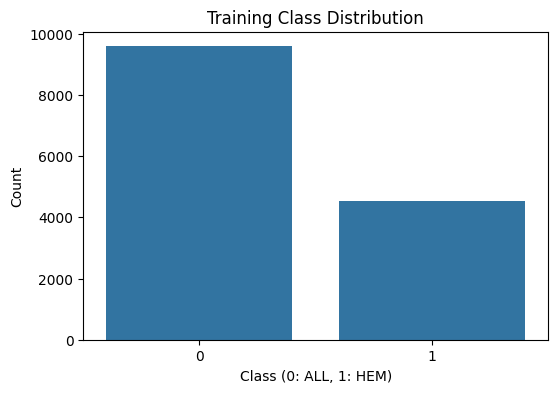

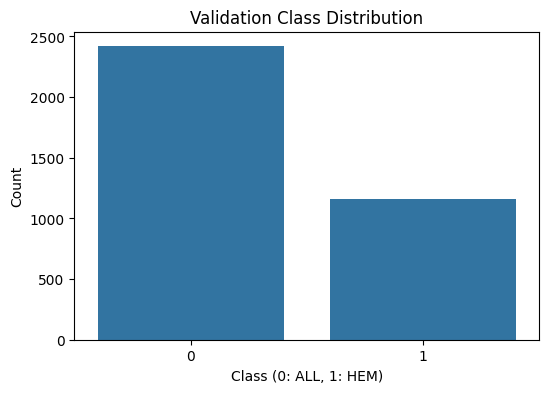

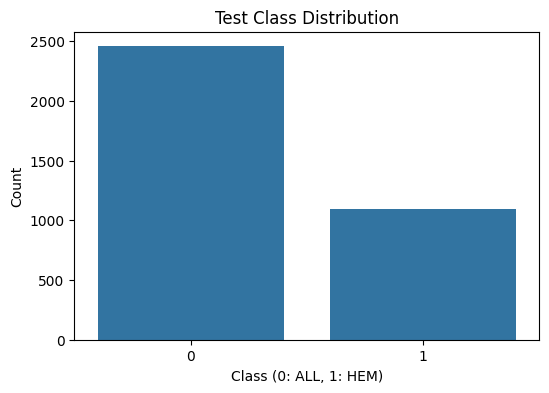

In [7]:
def plot_class_distribution(y, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel("Class (0: ALL, 1: HEM)")
    plt.ylabel("Count")
    plt.show()

y_train_all = extract_all_labels(train_gen)
y_val_all   = extract_all_labels(val_gen)
y_test_all  = extract_all_labels(test_gen)

# Plot
plot_class_distribution(y_train_all, "Training Class Distribution")
plot_class_distribution(y_val_all, "Validation Class Distribution")
plot_class_distribution(y_test_all, "Test Class Distribution")


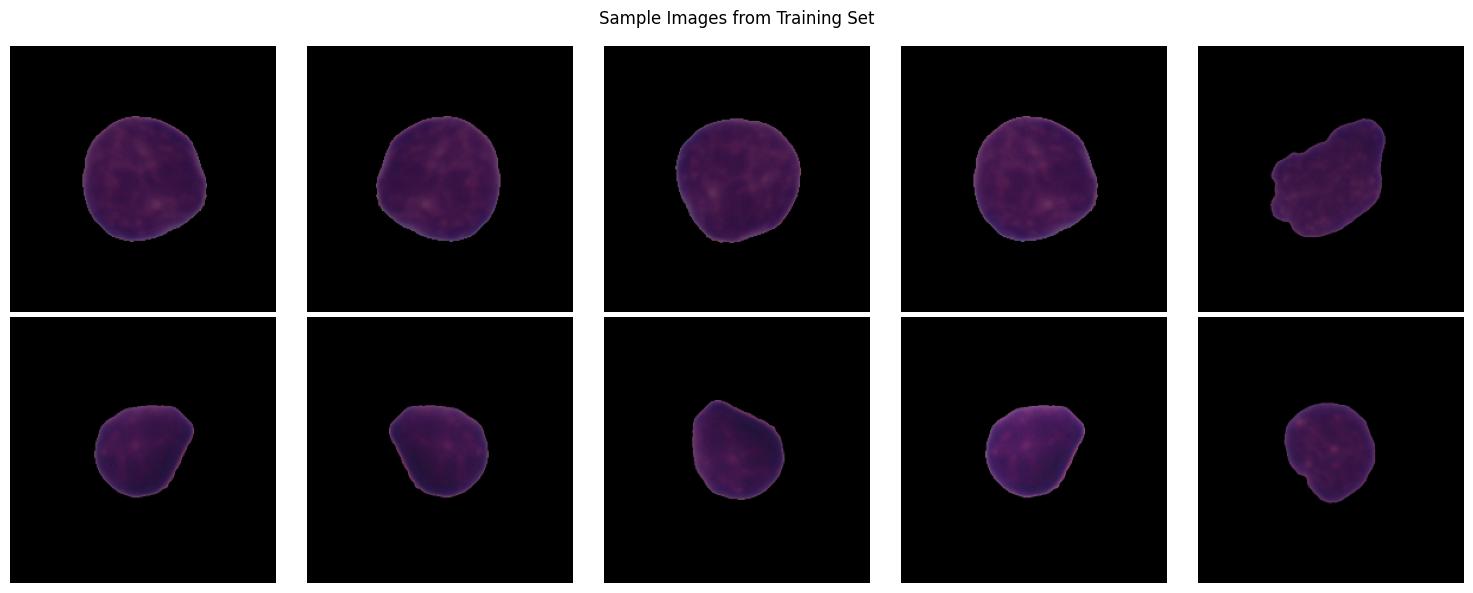

In [8]:
def get_sample_images(generator, num_per_class=5):
    images_by_class = {}
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        for img, label in zip(X_batch, y_batch):
            if label not in images_by_class:
                images_by_class[label] = []
            if len(images_by_class[label]) < num_per_class:
                images_by_class[label].append(img)
        # Stop early if we have enough for all classes
        if all(len(imgs) >= num_per_class for imgs in images_by_class.values()):
            break
    return images_by_class

def show_sample_images_from_generator(generator, label_map, title="Sample Images", num_samples=5):
    samples = get_sample_images(generator, num_samples)
    num_classes = len(samples)

    plt.figure(figsize=(15, 3 * num_classes))
    for row_idx, (label, images) in enumerate(samples.items()):
        for col_idx, img in enumerate(images):
            plt.subplot(num_classes, num_samples, row_idx * num_samples + col_idx + 1)
            plt.imshow(img)
            plt.axis('off')
            if col_idx == 0:
                plt.ylabel(label_map[label], fontsize=12)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

label_map = {0: "ALL", 1: "HEM"}
show_sample_images_from_generator(train_gen, label_map, "Sample Images from Training Set")


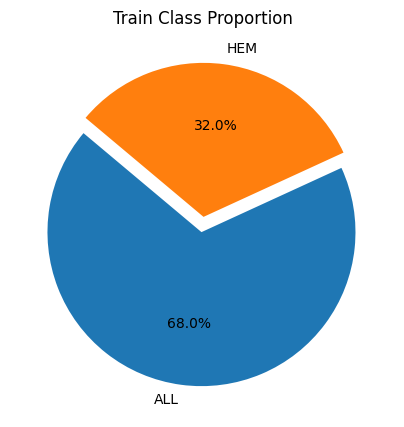

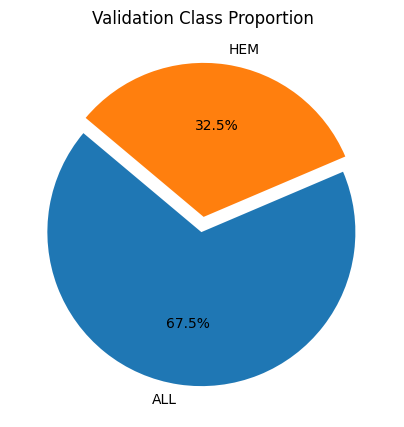

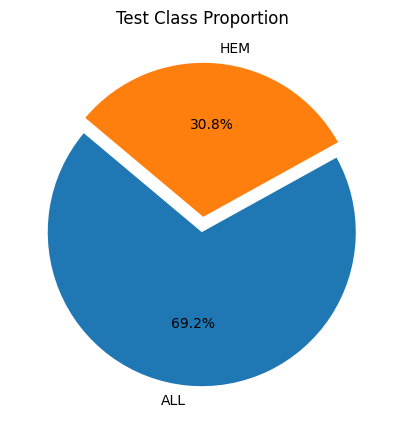

In [9]:
def plot_pie_chart(y, title):
    labels = ['ALL', 'HEM']
    counts = [np.sum(y == 0), np.sum(y == 1)]
    plt.figure(figsize=(5, 5))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, explode=(0.05, 0.05))
    plt.title(title)
    plt.show()

plot_pie_chart(y_train_all, "Train Class Proportion")
plot_pie_chart(y_val_all, "Validation Class Proportion")
plot_pie_chart(y_test_all, "Test Class Proportion")


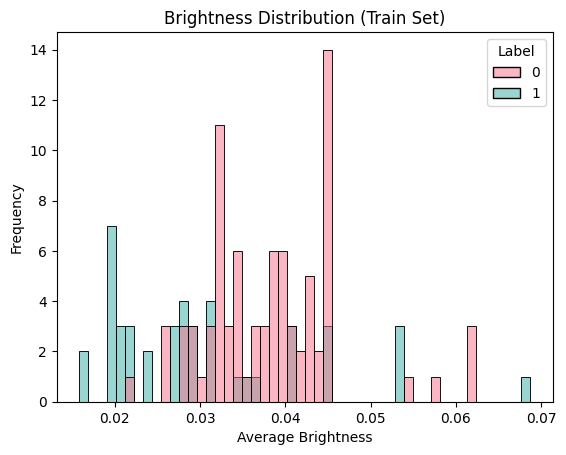

In [11]:
import pandas as pd

def plot_brightness_distribution(X, y, title):
    brightness = [np.mean(img) for img in X]
    sns.histplot(data=pd.DataFrame({'Brightness': brightness, 'Label': y}),
                 x="Brightness", hue="Label", bins=50, palette='husl')
    plt.title(title)
    plt.xlabel("Average Brightness")
    plt.ylabel("Frequency")
    plt.show()

plot_brightness_distribution(X_batch, y_batch, "Brightness Distribution (Train Set)")


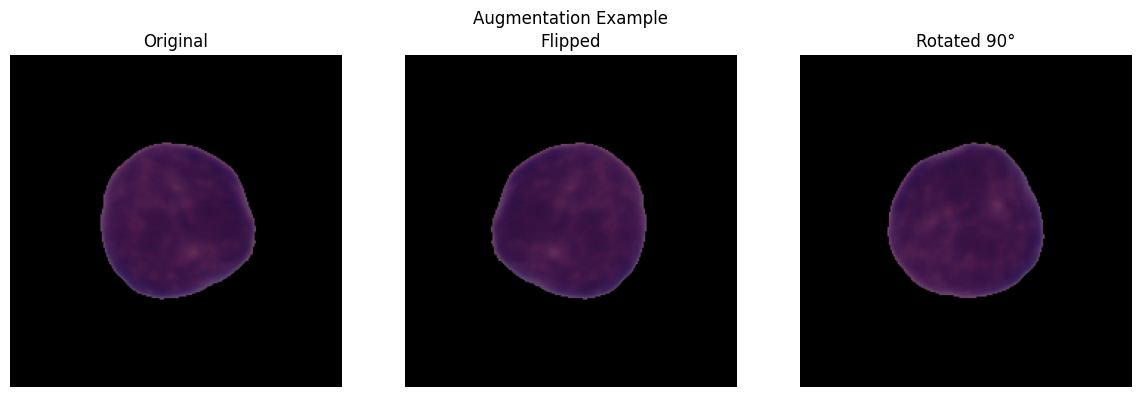

In [12]:
# low level augmentation
def show_augmentation_example(img):
    img = cv2.resize(img, IMG_SIZE)
    flipped = cv2.flip(img, 1)
    angle = 90
    M = cv2.getRotationMatrix2D((IMG_SIZE[0] // 2, IMG_SIZE[1] // 2), angle, 1)
    rotated = cv2.warpAffine(img, M, IMG_SIZE)

    images = [img, flipped, rotated]
    titles = ['Original', 'Flipped', 'Rotated 90°']

    plt.figure(figsize=(12, 4))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.suptitle("Augmentation Example")
    plt.tight_layout()
    plt.show()

# Show using a random training image
show_augmentation_example(X_batch[0])


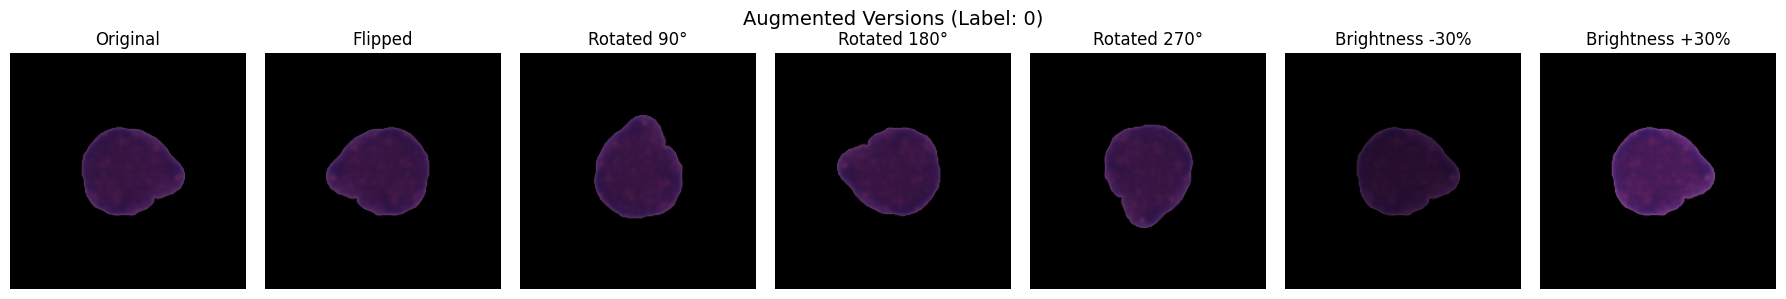

In [15]:
# more augmentations
def apply_augmentations_from_generator(generator, img, img_size=(224, 224)):
    augmented_images = [img]  # original

    # Horizontal flip
    flipped = cv2.flip(img, 1)
    augmented_images.append(flipped)

    # Random rotations
    for angle in [90, 180, 270]:
        M = cv2.getRotationMatrix2D((img_size[0] // 2, img_size[1] // 2), angle, 1)
        rotated = cv2.warpAffine(img, M, img_size)
        augmented_images.append(rotated)

    # Brightness jitter (show both dimmer and brighter)
    for brightness in [0.7, 1.3]:
        bright = np.clip(img * brightness, 0, 1).astype(np.float32)
        augmented_images.append(bright)

    return augmented_images

import matplotlib.pyplot as plt

def show_augmented_versions_from_generator(generator, img_size=(224, 224)):
    X_batch, y_batch = generator[0]
    img = X_batch[0]
    label = y_batch[0]

    aug_imgs = apply_augmentations_from_generator(generator, img, img_size)

    plt.figure(figsize=(18, 3))
    for i, aug_img in enumerate(aug_imgs):
        plt.subplot(1, len(aug_imgs), i + 1)
        plt.imshow(aug_img)
        plt.axis('off')
        titles = ['Original', 'Flipped', 'Rotated 90°', 'Rotated 180°', 'Rotated 270°', 'Brightness -30%', 'Brightness +30%']
        plt.title(titles[i])

    plt.suptitle(f"Augmented Versions (Label: {label})", fontsize=14)
    plt.tight_layout()
    plt.show()


# non-augmented generator to fetch the original clean image
clean_gen = LeukemiaDataGenerator(train_path, augment=False)
show_augmented_versions_from_generator(clean_gen)
